**Sentiment Analysis with Neural bag of words (NBoW) also known as CBoW(continous bag of words)**

In [50]:
!pip install torch==2.3.0 torchtext==0.18.0

In [51]:
!pip install datasets

In [52]:
import matplotlib.pyplot as plt

In [53]:
import collections
import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

**load data**

In [54]:
train_data,test_data = datasets.load_dataset("imdb",split=["train","test"])

In [55]:
train_data,test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [56]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [57]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

**Tokenization**

In [58]:
from torchtext.data import get_tokenizer

In [59]:
def tokenize_example(example,tokenizer,max_length):
  tokens=tokenizer(example["text"])[:max_length]
  return {"tokens":tokens}

In [60]:
max_length=256
train_data=train_data.map(tokenize_example,fn_kwargs={"tokenizer":tokenizer,"max_length":max_length})
test_data=test_data.map(tokenize_example,fn_kwargs={"tokenizer":tokenizer,"max_length":max_length})

In [61]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

In [62]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [63]:
train_data[0]["tokens"][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

**Validation Data**

In [64]:
test_size=0.25
train_valid_data=train_data.train_test_split(test_size=test_size)
train_data=train_valid_data["train"]
valid_data=train_valid_data["test"]

In [65]:
len(train_data),len(test_data),len(valid_data)

(18750, 25000, 6250)

**Vocabulary**

In [66]:
from torchtext.vocab import build_vocab_from_iterator

In [67]:
min_freq=5
special_tokens=["<unk>","<pad>"]
vocab=build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [68]:
len(vocab)

21534

In [69]:
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

In [70]:
vocab["and"]

6

In [71]:
unk_index=vocab["<unk>"]
pad_index=vocab["<pad>"]

In [72]:
"some_token" in vocab

False

In [73]:
#vocab["some_token"]

In [74]:
vocab.set_default_index(unk_index)

In [75]:
vocab["some_index"]

0

In [76]:
vocab.lookup_indices(["hello","world","some_token"])

[4854, 185, 0]

**numericalize data**

In [77]:
def numericalize_data(example,vocab):
  ids=vocab.lookup_indices(example["tokens"])
  return {"ids" : ids}

In [78]:
train_data=train_data.map(numericalize_data,fn_kwargs={"vocab":vocab})
valid_data=valid_data.map(numericalize_data,fn_kwargs={"vocab":vocab})
test_data=test_data.map(numericalize_data,fn_kwargs={"vocab":vocab})

Map: 100%|██████████| 25000/25000 [00:03<00:00, 6395.31 examples/s]


In [79]:
train_data

Dataset({
    features: ['text', 'label', 'tokens', 'ids'],
    num_rows: 18750
})

In [80]:
train_data[0]["tokens"][:10]

['the', 'first', 'film', 'was', 'a', 'nice', 'one', ',', 'but', 'it']

In [81]:
vocab.lookup_indices(train_data[0]["tokens"][:10])

[2, 80, 23, 17, 5, 339, 34, 4, 22, 11]

In [82]:
train_data[0]["ids"][:10]

[2, 80, 23, 17, 5, 339, 34, 4, 22, 11]

**Converting into tensors**

In [83]:
train_data

Dataset({
    features: ['text', 'label', 'tokens', 'ids'],
    num_rows: 18750
})

In [84]:
train_data=train_data.with_format(type="torch",columns=["ids","label"])
valid_data=valid_data.with_format(type="torch",columns=["ids","label"])
test_data=test_data.with_format(type="torch",columns=["ids","label"])

In [85]:
train_data[0]["label"]

tensor(1)

In [86]:
train_data[0].keys()

dict_keys(['label', 'ids'])

In [87]:
vocab.lookup_tokens(train_data[0]["ids"][:10].tolist())

['the', 'first', 'film', 'was', 'a', 'nice', 'one', ',', 'but', 'it']

### **`Creating DataLoaders`**

In [88]:
def get_collate_fn(pad_index):

  def collate_fn(batch):

    batch_ids=[i["ids"] for i in batch]

    batch_ids=nn.utils.rnn.pad_sequence(
        batch_ids,
        padding_value = pad_index,
        batch_first = True
    )

    batch_label = [i["label"] for i in batch]
    batch_label = torch.stack(batch_label)

    batch = {"ids":batch_ids,"label":batch_label}

    return batch

  return collate_fn

In [89]:
def get_data_loader(dataset,batch_size,pad_index,shuffle=False):

  collate_fn = get_collate_fn(pad_index)

  data_loader=torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      collate_fn=collate_fn,
      shuffle=shuffle,
  )

  return data_loader

In [ ]:
batch_size=512

train_data_loader = get_data_loader(train_data,batch_size,pad_index,shuffle=True)

valid_data_loader = get_data_loader(valid_data,batch_size,pad_index)

test_data_loader = get_data_loader(test_data,batch_size,pad_index)

In [91]:
len(train_data_loader)

37

In [92]:
len(valid_data_loader)

13

In [93]:
len(test_data_loader)

49

**Build the model**

In [ ]:
class NBoW(nn.Module):

  def __init__(self,vocab_size,embedding_dim,output_dim,pad_index):
    
    super().__init__()
    
    self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=pad_index)

    self.fc=nn.Linear(embedding_dim,output_dim)

  def forward(self,ids):

    embedded=self.embedding(ids)

    pooled=embedded.mean(dim=1)

    prediction=self.fc(pooled)

    return prediction

In [95]:
vocab_size=len(vocab)
embedding_dim=300
output_dim=len(train_data.unique("label"))
model=NBoW(vocab_size,embedding_dim,output_dim,pad_index)

In [96]:
len(vocab)

21534

In [97]:
len(train_data.unique("label"))

2

In [98]:
def count_parameters(model):
  return   sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"the model has{count_parameters(model):,} trainable parameters")

the model has6,460,802 trainable parameters


**this will take a lot of time , so we use glove here**

In [99]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [07:08, 5.08MB/s]                                
100%|█████████▉| 2196016/2196017 [02:03<00:00, 17764.89it/s]


In [100]:
hello_vector = vectors.get_vecs_by_tokens("hello")

In [101]:
hello_vector.shape

torch.Size([300])

In [102]:
hello_vector[:32]

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154])

In [103]:
pretrained_embedding=vectors.get_vecs_by_tokens(vocab.get_itos())

In [104]:
pretrained_embedding.shape

torch.Size([21534, 300])

In [105]:
model.embedding.weight

Parameter containing:
tensor([[-0.0434, -0.1151, -1.1020,  ..., -0.2297,  0.6971, -1.1617],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.8872,  1.4432,  1.0139,  ...,  0.8877,  0.2991,  0.7252],
        ...,
        [-0.4611, -0.5647,  0.7538,  ...,  2.1667, -0.6122, -0.1628],
        [-0.7026,  1.4751,  0.2342,  ..., -0.6488, -0.2551, -1.3664],
        [-1.7077, -0.2743,  0.0303,  ..., -1.1587,  0.9979, -0.9275]],
       requires_grad=True)

In [106]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.6701, -0.2717,  0.4766,  ...,  0.2786,  0.3312,  0.0230],
        [ 0.1034,  0.0618, -0.3565,  ..., -0.0621, -0.5939, -0.1527],
        [ 0.2701,  0.6335,  0.2016,  ..., -0.4568,  0.5783, -0.5545]])

In [107]:
model.embedding.weight.data=pretrained_embedding

In [108]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.6701, -0.2717,  0.4766,  ...,  0.2786,  0.3312,  0.0230],
        [ 0.1034,  0.0618, -0.3565,  ..., -0.0621, -0.5939, -0.1527],
        [ 0.2701,  0.6335,  0.2016,  ..., -0.4568,  0.5783, -0.5545]],
       requires_grad=True)

**Loss function and optimizer**

In [109]:
optimizer=optim.Adam(model.parameters())

In [110]:
criterion=nn.CrossEntropyLoss()

In [111]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [112]:
model=model.to(device)
criterion=criterion.to(device)

**Training and Evaluate Function**

In [113]:
def train(data_loader,model,criterion,optimizer,device):
  model.train()
  epoch_losses=[]
  epoch_accs=[]
  for batch  in tqdm.tqdm(data_loader,desc="training..."):
    ids=batch["ids"].to(device)
    label=batch["label"].to(device)
    prediction=model(ids)
    loss=criterion(prediction,label)
    accuracy=get_accuracy(prediction,label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    epoch_accs.append(accuracy.item())
  return np.mean(epoch_losses),np.mean(epoch_accs)

In [114]:
def evaluate(data_loader,model,criterion,device):
  model.eval()
  epoch_losses=[]
  epoch_accs=[]
  with torch.no_grad():
    for batch in tqdm.tqdm(data_loader,desc="evaluating..."):
      ids=batch["ids"].to(device)
      label=batch["label"].to(device)
      prediction=model(ids)
      loss=criterion(prediction,label)
      accuracy=get_accuracy(prediction,label)
      epoch_losses.append(loss.item())
      epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses),np.mean(epoch_accs)



In [115]:
def get_accuracy(prediction,label):
  batch_size,_=prediction.shape
  predicted_classes=prediction.argmax(dim=-1)
  correct_prediction=predicted_classes.eq(label).sum()
  accuracy=correct_prediction / batch_size
  return accuracy

**Starting Loop**

In [116]:
n_epochs=10
best_valid_loss=float("inf")
metrics=collections.defaultdict(list)
for epoch in range(n_epochs):
  train_loss,train_acc=train(train_data_loader,model,criterion,optimizer,device)
  valid_loss,valid_acc=evaluate(valid_data_loader,model,criterion,device)
  metrics["train_losses"].append(train_loss)
  metrics["train_accs"].append(train_acc)
  metrics["valid_losses"].append(valid_loss)
  metrics["valid_acc"].append(valid_acc)
  if valid_loss <best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),"nbow.pt")
  print(f"epoch:{epoch}")
  print(f"train_loss: {train_loss:.3f},train_acc: {train_acc:.3f}")
  print(f"valid_loss:{valid_loss:.3f},valid_acc: {valid_acc:3f}")

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 56.70it/s]


epoch:0
train_loss: 0.680,train_acc: 0.648
valid_loss:0.662,valid_acc: 0.680935


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 56.63it/s]


epoch:1
train_loss: 0.638,train_acc: 0.729
valid_loss:0.613,valid_acc: 0.747710


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 56.48it/s]


epoch:2
train_loss: 0.576,train_acc: 0.772
valid_loss:0.548,valid_acc: 0.787846


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 56.02it/s]


epoch:3
train_loss: 0.505,train_acc: 0.814
valid_loss:0.483,valid_acc: 0.825202


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 55.30it/s]


epoch:4
train_loss: 0.437,train_acc: 0.851
valid_loss:0.429,valid_acc: 0.846111


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 55.23it/s]


epoch:5
train_loss: 0.383,train_acc: 0.871
valid_loss:0.390,valid_acc: 0.856427


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 56.42it/s]


epoch:6
train_loss: 0.342,train_acc: 0.885
valid_loss:0.362,valid_acc: 0.865991


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 57.07it/s]


epoch:7
train_loss: 0.308,train_acc: 0.896
valid_loss:0.341,valid_acc: 0.869597


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 57.21it/s]


epoch:8
train_loss: 0.282,train_acc: 0.906
valid_loss:0.325,valid_acc: 0.875456


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 55.76it/s]

epoch:9
train_loss: 0.259,train_acc: 0.915
valid_loss:0.313,valid_acc: 0.880114


**visulizeing**

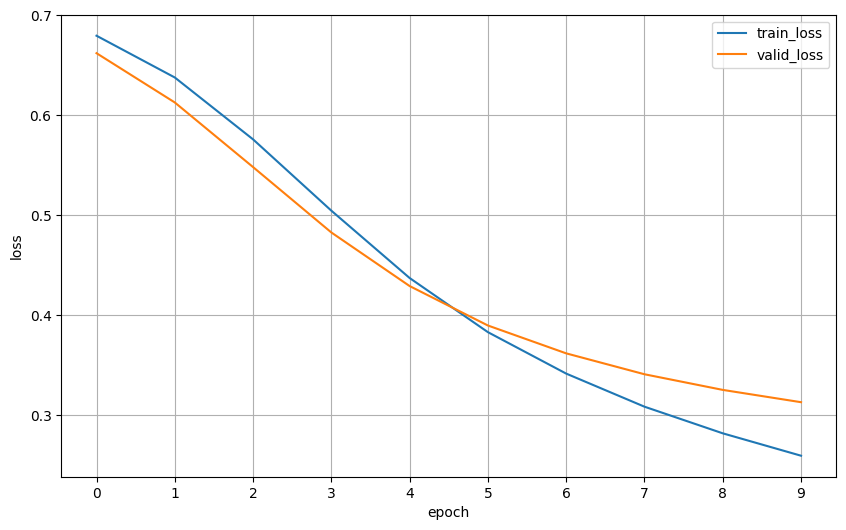

In [117]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
ax.plot(metrics["train_losses"],label="train_loss")
ax.plot(metrics["valid_losses"],label="valid_loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

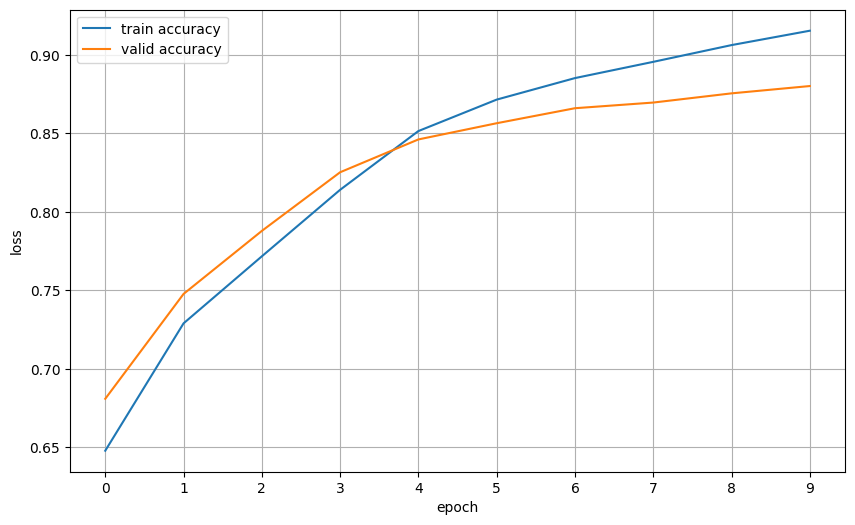

In [118]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_acc"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [119]:
model.load_state_dict(torch.load("nbow.pt"))
test_loss,test_acc=evaluate(test_data_loader,model,criterion,device)

evaluating...: 100%|██████████| 49/49 [00:00<00:00, 51.65it/s]


In [120]:
print(f"test_loss: {test_loss:.3f},test_acc:{test_acc:.3f}")

test_loss: 0.350,test_acc:0.859


**testing model on new sentence**

In [121]:
def predict_sentiment(text,model,tokenizer,vocab,device):
  tokens=tokenizer(text)
  ids=vocab.lookup_indices(tokens)
  tensor=torch.LongTensor(ids).unsqueeze(dim=0).to(device)
  prediction=model(tensor).squeeze(dim=0)
  probability=torch.softmax(prediction,dim=-1)
  predicted_class=prediction.argmax(dim=-1).item()
  predicted_probability=probability[predicted_class].item()
  return predicted_class,predicted_probability


In [122]:
text="this film is terrible"
predict_sentiment(text,model,tokenizer,vocab,device)

(0, 1.0)

In [123]:
text="this film is great"
predict_sentiment(text,model,tokenizer,vocab,device)

(1, 1.0)

In [124]:
text="this film is not terrible,it's great!"
predict_sentiment(text,model,tokenizer,vocab,device)

(1, 0.7470009326934814)